In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

## DATOS

In [2]:
smart_inferidos = pd.read_csv('base_total_DL.csv', sep = ',')

In [3]:
smart_irregulares = pd.read_csv('BASES_FINALES_DL/smart_inferidos_irregulares.csv', sep = ',')
smart_regulares = pd.read_csv('BASES_FINALES_DL/smart_inferidos_regulares.csv', sep = ',')
smart_irregulares2 = pd.read_csv('smart_inferidos_irregulares2.csv', sep = ',') #Ajustado modelo
smart_regulares2 = pd.read_csv('smart_inferidos_regulares2.csv', sep = ',') #Ajustado modelo

In [4]:
smart_inferidos = smart_inferidos.drop(columns=['ParadaRegreso', 'FechaHoraRegreso'])
smart_inferidos = smart_inferidos.rename(columns={'ParadaAscenso_Nombre': 'Origen'})
smart_inferidos = smart_inferidos.rename(columns={'FechaHoraAscenso': 'FechaHoraValidacion'})
smart_inferidos = smart_inferidos.rename(columns={'LineaViaje': 'CodigoLinea'})

In [5]:
stops_data = pd.read_csv('stop_data_linea.csv', sep = ',')
stops_data['ID-PARADA_2'] = stops_data['ID-PARADA_2'].apply(ast.literal_eval)

In [6]:
smart_filtrado = smart_inferidos[smart_inferidos['Origen'] != smart_inferidos['Destino']]
flujo_df = smart_filtrado.groupby(['Origen', 'Destino']).size().reset_index(name='Flujo')

In [7]:
flujo_df = flujo_df[flujo_df['Origen'] != flujo_df['Destino']].copy()

# 2. Crear columnas ordenadas para identificar pares sin importar la dirección
flujo_df['id_a'] = flujo_df[['Origen', 'Destino']].min(axis=1)
flujo_df['id_b'] = flujo_df[['Origen', 'Destino']].max(axis=1)

# 3. Etiquetar la dirección original del flujo
flujo_df['direccion'] = flujo_df.apply(lambda x: 'ab' if x['Origen'] == x['id_a'] else 'ba', axis=1)

# 4. Separar los flujos ab y ba
flow_ab = flujo_df[flujo_df['direccion'] == 'ab'][['id_a', 'id_b', 'Flujo']].rename(columns={'Flujo': 'flow_ab'})
flow_ba = flujo_df[flujo_df['direccion'] == 'ba'][['id_a', 'id_b', 'Flujo']].rename(columns={'Flujo': 'flow_ba'})

# 5. Unir ambos flujos en una sola tabla
flujo_final = pd.merge(flow_ab, flow_ba, on=['id_a', 'id_b'], how='outer')

# 6. Rellenar los flujos faltantes con 0
flujo_final['flow_ab'] = flujo_final['flow_ab'].fillna(0)
flujo_final['flow_ba'] = flujo_final['flow_ba'].fillna(0)


In [7]:
nodos_a = nodos.rename(columns={
    'full_id': 'id_a',
    'LONGITUD': 'xa',
    'LATITUD': 'ya'
})

# Renombrar nodos para el merge con destino (id_b)
nodos_b = nodos.rename(columns={
    'full_id': 'id_b',
    'LONGITUD': 'xb',
    'LATITUD': 'yb'
})

# Merge para agregar coordenadas del origen
total = flujo_final.merge(nodos_a, on='id_a', how='left')

# Merge para agregar coordenadas del destino
total = total.merge(nodos_b, on='id_b', how='left')


NameError: name 'nodos' is not defined

In [27]:
total.to_csv('flujo_parroquia.csv', index = False)

In [10]:
# Unir todas las bases en un solo DataFrame
bases = [smart_inferidos[['Origen', 'Destino']]]
df_flujos = pd.concat(bases, ignore_index=True)
# Tratar el grafo como NO dirigido
# Ordenamos los pares Origen-Destino alfabéticamente para agrupar sin dirección
df_flujos['nodo1'] = df_flujos[['Origen', 'Destino']].min(axis=1)
df_flujos['nodo2'] = df_flujos[['Origen', 'Destino']].max(axis=1)
# Agrupar para contar cuántos flujos existen entre cada par
df_flujos_agrupado = df_flujos.groupby(['nodo1', 'nodo2']).size().reset_index(name='flujo')

In [8]:
# Renombrar para trabajar más cómodo
stops = stops_data.rename(columns={'ID-PARADA': 'parada', 'LONGITUD': 'lon', 'LATITUD': 'lat'})

# Unir coordenadas de origen
df_geo = df_flujos_agrupado.merge(stops, left_on='nodo1', right_on='parada')
df_geo = df_geo.rename(columns={'lat': 'lat_origen', 'lon': 'lon_origen'})
df_geo = df_geo.drop(columns='parada')

# Unir coordenadas de destino
df_geo = df_geo.merge(stops, left_on='nodo2', right_on='parada')
df_geo = df_geo.rename(columns={'lat': 'lat_destino', 'lon': 'lon_destino'})
df_geo = df_geo.drop(columns='parada')


In [9]:
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx

# Crear geometrías de línea
df_geo['geometry'] = df_geo.apply(lambda row: LineString([(row['lon_origen'], row['lat_origen']),
                                                          (row['lon_destino'], row['lat_destino'])]), axis=1)

gdf_lineas = gpd.GeoDataFrame(df_geo, geometry='geometry', crs='EPSG:4326')

# Convertir a proyección métrica para poder usar contextily
gdf_lineas = gdf_lineas.to_crs(epsg=3857)

# Normalizar el flujo para grosores y colores
flujo_max = gdf_lineas['flujo'].max()
gdf_lineas['ancho'] = gdf_lineas['flujo'] / flujo_max * 5  # ancho entre 0 y 5
gdf_lineas['color'] = gdf_lineas['flujo'] / flujo_max  # color en escala 0–1


C:\Users\lenovo\AppData\Local\Temp\ipykernel_21832\1561603875.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # Invertido: verde (bajo) → rojo (alto)


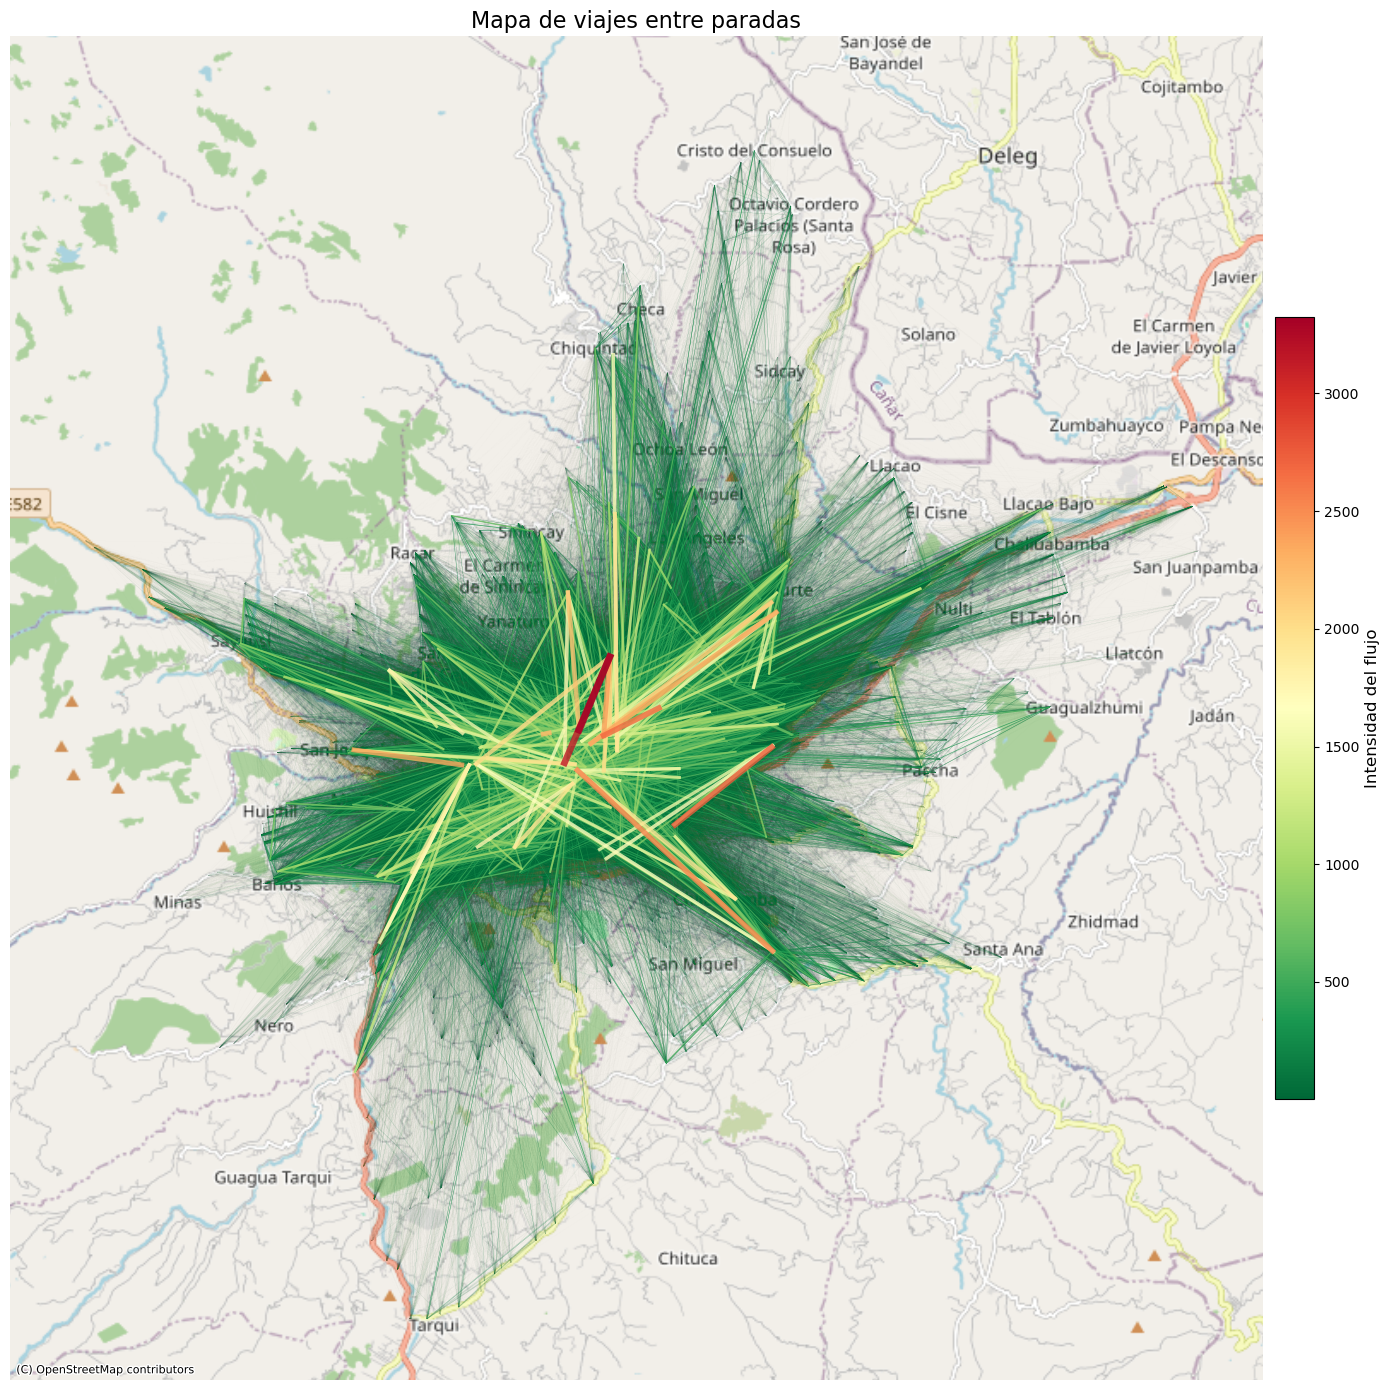

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

# Ordenar para que flujos grandes estén encima
gdf_lineas = gdf_lineas.sort_values(by='flujo')

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(14, 14))

# Crear mapa de colores verde → rojo
cmap = plt.cm.get_cmap('RdYlGn_r')  # Invertido: verde (bajo) → rojo (alto)
norm = mcolors.Normalize(vmin=gdf_lineas['flujo'].min(), vmax=gdf_lineas['flujo'].max())

# Dibujar las líneas con color dinámico
for _, row in gdf_lineas.iterrows():
    ax.plot(*row.geometry.xy,
            color=cmap(norm(row['flujo'])),
            linewidth=row['ancho'],
            alpha=0.8)

# Agregar mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Crear barra de color como leyenda
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # requerido por colorbar
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label('Intensidad del flujo', fontsize=12)

# Opcional: título y limpieza de ejes
plt.title('Mapa de viajes entre paradas', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("mapa_flujos.png", dpi=600, bbox_inches='tight')
plt.show()

In [5]:
parroquias = pd.read_csv('parroquias_paradas.csv', sep = ',')

In [6]:
parroquias[['LONGITUD', 'LATITUD', 'ID-PARADA', 'full_id', 'wikipedia', 'admin_level']]

,LONGITUD,LATITUD,ID-PARADA,full_id,wikipedia,admin_level
0,-78.946328,-2.793247,27,r3684242,NaN,8
1,-78.901188,-2.835379,194,r3691766,NaN,8
2,-78.953866,-2.844430,261,r3693131,NaN,8
3,-78.953665,-2.844410,263,r3693131,NaN,8
4,-78.953575,-2.846417,292,r3693131,NaN,8
...,...,...,...,...,...,...
2408,-79.042073,-2.914526,4206,r3845861,NaN,9
2409,-79.045495,-2.921579,4425,r3845861,NaN,9
2410,-79.046674,-2.917494,4438,r3845861,NaN,9
2411,-79.042373,-2.927359,4534,r3845861,NaN,9


In [7]:
mapa = dict(zip(parroquias['ID-PARADA'], parroquias['full_id']))

# Reemplazar en las columnas Origen y Destino
smart_inferidos['Origen'] = smart_inferidos['Origen'].map(mapa)
smart_inferidos['Destino'] = smart_inferidos['Destino'].map(mapa)

In [10]:
import geopandas as gpd

# Leer el GeoPackage
gdf = gpd.read_file("parroquias_definitivas.gpkg")


In [12]:
gdf['centroide'] = gdf.geometry.centroid

# Si quieres las coordenadas (x, y) en columnas separadas
gdf['x'] = gdf['centroide'].x
gdf['y'] = gdf['centroide'].y


C:\Users\lenovo\AppData\Local\Temp\ipykernel_21968\191071574.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroide'] = gdf.geometry.centroid


In [20]:
nodos = gdf[['full_id', 'x', 'y']]
nodos = nodos.rename(columns={'x': 'LONGITUD', 'y': 'LATITUD'})

## TENDENCIAS

In [24]:
columnas = ['Origen', 'Destino', 'CodigoLinea', 'FechaHoraValidacion']
df1 = smart_inferidos[columnas]
df2 = smart_regulares2[columnas]
df3 = smart_irregulares2[columnas]
df_total = pd.concat([df1, df2, df3], ignore_index=True)